In [6]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [8]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_actual = eps_actual[P].rank(1,pct=True,ascending=True).clip(0.01,0.99)

In [9]:
earnings.xs('A',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/a/earnings

#more generally we remark almost of all the time correct report date, but we're  still data source dependent


,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2022-05-24,2022-05-24,2022-04-30,AfterMarket,USD,1.13,1.12,0.01,0.8929
2022-08-16,2022-08-16,2022-07-31,AfterMarket,USD,1.34,1.20,0.14,11.6667
2022-11-21,2022-11-21,2022-10-31,AfterMarket,USD,1.53,1.39,0.14,10.0719
2023-02-28,2023-02-28,2023-01-31,AfterMarket,USD,1.37,1.30,0.07,5.3846


In [10]:
earnings.xs('UNH',level=1).tail(4)
### accurate but small differences with https://www.nasdaq.com/market-activity/stocks/unh/earnings


,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,,,,,,,,
2022-04-14,2022-04-14,2022-03-31,BeforeMarket,USD,5.49,5.38,0.11,2.0446
2022-07-15,2022-07-15,2022-06-30,BeforeMarket,USD,5.57,5.20,0.37,7.1154
2022-10-14,2022-10-14,2022-09-30,BeforeMarket,USD,5.79,5.42,0.37,6.8266
2023-01-13,2023-01-13,2022-12-31,None,USD,5.34,5.17,0.17,3.2882


In [11]:
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module

__all__ = ['broadcast_to', 'broadcast_arrays', 'broadcast_shapes']


class DummyArray:
    """Dummy object that just exists to hang __array_interface__ dictionaries
    and possibly keep alive a reference to a base array.
    """

    def __init__(self, interface, base=None):
        self.__array_interface__ = interface
        self.base = base



def _maybe_view_as_subclass(original_array, new_array):
    if type(original_array) is not type(new_array):
        # if input was an ndarray subclass and subclasses were OK,
        # then view the result as that subclass.
        new_array = new_array.view(type=type(original_array))
        # Since we have done something akin to a view from original_array, we
        # should let the subclass finalize (if it has it implemented, i.e., is
        # not None).
        if new_array.__array_finalize__:
            new_array.__array_finalize__(original_array)
    return new_array

In [12]:
def as_strided(x, shape=None, strides=None, subok=False, writeable=True):

    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)
    interface = dict(x.__array_interface__)
    if shape is not None:
        interface['shape'] = tuple(shape)
    if strides is not None:
        interface['strides'] = tuple(strides)

    array = np.asarray(DummyArray(interface, base=x))
    # The route via `__interface__` does not preserve structured
    # dtypes. Since dtype should remain unchanged, we set it explicitly.
    array.dtype = x.dtype

    view = _maybe_view_as_subclass(x, array)

    if view.flags.writeable and not writeable:
        view.flags.writeable = False

    return view

In [13]:
def sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)


In [14]:
def linreg(close, length=None, offset=None, **kwargs):
    
    """Indicator: Linear Regression"""
    # Validate arguments
    length = int(length) if length and length > 0 else 14
    angle = kwargs.pop("angle", False)
    intercept = kwargs.pop("intercept", False)
    r = kwargs.pop("r", False)
    slope = kwargs.pop("slope", False)
    tsf = kwargs.pop("tsf", False)
    offset = int(offset) if offset else 0

    if close is None: return

    # Calculate Result
    x = range(1, length + 1)
    x_sum = 0.5 * length * (length + 1)
    x2_sum = x_sum * (2 * length + 1) / 3
    divisor = length * x2_sum - x_sum * x_sum

    def linear_regression(series):
        y_sum = series.sum()
        xy_sum = (x * series).sum()

        m = (length * xy_sum - x_sum * y_sum) / divisor
        if slope:
            return m
        b = (y_sum * x2_sum - x_sum * xy_sum) / divisor
        if intercept:
            return b

        if r:
            y2_sum = (series * series).sum()
            rn = length * xy_sum - x_sum * y_sum
            rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
            return rn / rd

        return m * length + b if tsf else m * (length - 1) + b


    from numpy.lib.stride_tricks import sliding_window_view
    linreg_ = [linear_regression(_) for _ in sliding_window_view(np.array(close), length)]


    linreg = pd.Series([np.nan] * (length - 1) + linreg_, index=close.index)

    # Offset
    if offset != 0:
        linreg = linreg.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        linreg.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        linreg.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    linreg.name = f"LR"
    if slope: linreg.name += "m"
    if intercept: linreg.name += "b"
    if angle: linreg.name += "a"
    if r: linreg.name += "r"

    linreg.name += f"_{length}"
    linreg.category = "overlap"

    return linreg


In [15]:
def forecast_oscillator(close, length=None, scalar=None, drift=None, offset=None, **kwargs):
    """Indicator: Chande Forcast Oscillator (CFO)"""
    # Validate Arguments
    length = int(length) if length and length > 0 else 9
    scalar = float(scalar) if scalar else 100
    drift = drift if drift else 1
    offset = offset if offset else 0

    if close is None: return

    # Finding linear regression of Series
    change_forecast = scalar * (close - linreg(close, length=length, tsf=True,angle=True))
    change_forecast /= close

    # Offset
    if offset != 0:
        change_forecast = change_forecast.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        change_forecast.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        change_forecast.fillna(method=kwargs["fill_method"], inplace=True)

    return change_forecast

In [16]:
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float).rank(1,pct=True,ascending=True)
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    try :
        metrics = forecast_oscillator(eps[ticker],length=5).fillna(0)
        results[ticker] = metrics

    except :
        print(ticker)
metrics = pd.concat(results,axis=1).reindex_like(P).ffill()


100%|██████████| 866/866 [00:53<00:00, 16.22it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_22436\4250172003.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)


Sharpe                      1.5
Daily Turnover (%)        124.5
biais (bp)                  1.6
Sharpe since 2022           3.5
biais  since 2022 (bp)      3.6
dtype: float64

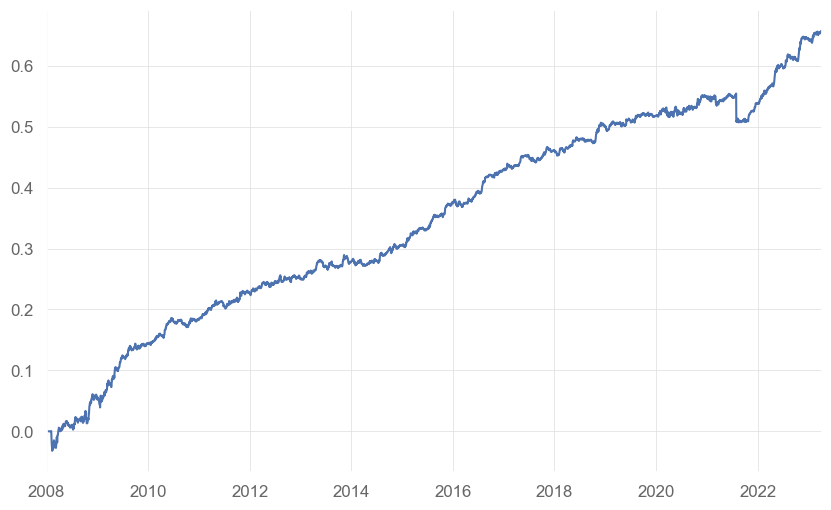

In [26]:
signal = metrics[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<1] = 0

signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

<Axes: >

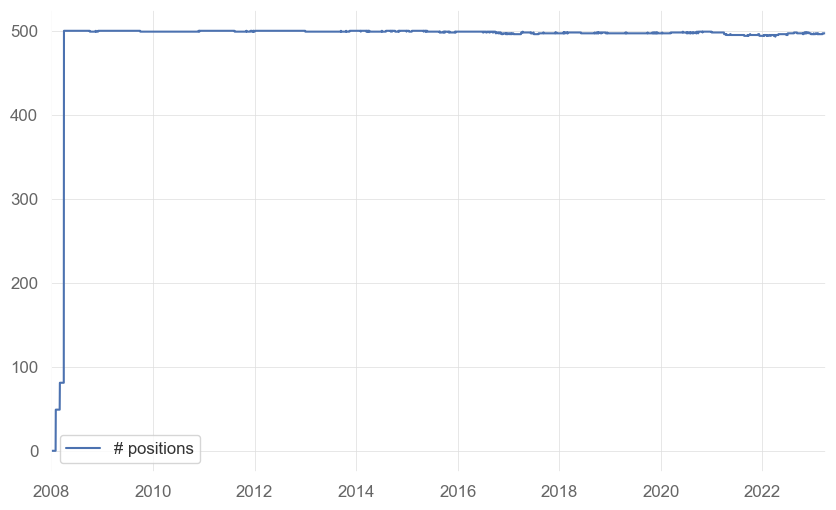

In [27]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

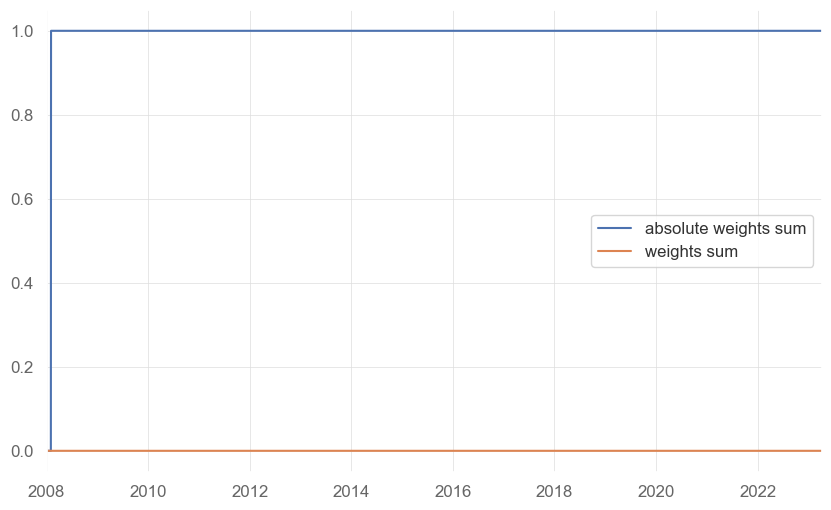

In [28]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)